<a href="https://colab.research.google.com/github/AmandinChyba/Project1-Fields-2022/blob/main/Walk_on_Boundary_and_BIEM/WalkOnBoundary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import jax
from jax import lax
from jax import random

import jax.numpy as jnp
import numpy as np

import time

import matplotlib.pyplot as plt

from functools import partial

In [13]:
@jax.jit
def unit_circle_distance(p): # signed distance function for 2d unit circle
  return jnp.linalg.norm(p,ord=2,axis=0) - 1

In [14]:
@jax.jit
def boundaryCond(p):
  return p[1]

In [15]:
@jax.jit
def binaryRootSearch(p0, p1, epochs, dir):
  p1 = p0 + p1 # need to center p1 at p0

  current = jnp.zeros((jnp.size(p0, 1), jnp.size(p0, 2)))

  def binaryStep(i, current):
    next = current + jnp.power(0.5,i+1)
    dist = unit_circle_distance(p0 + dir * next * (p1 - p0))
    return jnp.where(dist > 0, current, next)

  current = lax.fori_loop(0, epochs, binaryStep, current)
  
  return p0 + dir * current * (p1 - p0), current # return the roots, t-values

In [1017]:
@jax.jit
def wob(p0, p1, t, epochs):
  
  pFirst, tFirst = binaryRootSearch(p0, p1[0], epochs, 1)
  def wobStep(i, next):
    est = next[1] + 2 * jnp.power(-1,i+1) * boundaryCond(next[0])

    pBack, tBack = binaryRootSearch(next[0], p1[i], epochs, -1)
    pFor, tFor = binaryRootSearch(next[0], p1[i], epochs, 1)
    pNext = jnp.where(tBack > tFor, pBack, pFor)
    return (pNext, est)

  est = jnp.zeros((jnp.size(p1,2),jnp.size(p1, 3)))
  pLast, est = lax.fori_loop(1, t, wobStep, (pFirst, est))
  return est + jnp.power(-1, t+1) * boundaryCond(pLast)
  '''
  runningEst = jnp.zeros((jnp.size(p0,1),jnp.size(p0,2)))
  runningSign = 1

  pNext, tFirst = binaryRootSearch(p0, p1[0], epochs, 1)

  for p in p1[1:]:
    runningEst += runningSign * boundaryCond(pNext)
    runningSign *= -1
    pBack, tBack = binaryRootSearch(pNext, p, epochs, -1)
    pFor, tFor = binaryRootSearch(pNext, p, epochs, 1)
    pNext = jnp.where(tBack - tFor > 0, pBack, pFor)

  runningEst *= 2
  runningEst += runningSign * boundaryCond(pNext)
  return runningEst
  '''

In [17]:
def computeSoln(t, epochs, batches, p, key):
  p = jnp.reshape(p, (jnp.size(p,0), jnp.size(p,1), 1))
  p0 = jnp.tile(p, (1,1,batches))

  # generate random directions in n-dimensions
  diameter = 2
  p1 = random.normal(key, shape=(t, jnp.size(p, 0), jnp.size(p, 1), batches))
  normalize = jnp.linalg.norm(p1, ord=2, axis=1, keepdims=True)
  p1 = diameter * jnp.divide(p1, normalize)

  ans = wob(p0, p1, t, epochs)
  return jnp.mean(ans, 1)

In [1016]:
%%time
key = random.PRNGKey(int(time.time()))
x = jnp.array([[0.5,0,0.2],[0,0.15,0.7]]).transpose()
#x = jnp.array([[0.5,0.3]]).transpose()

print(computeSoln(10, 15, 100000, x, key))

(10, 3, 2, 100000)
[0.01606826 0.15230358]
CPU times: user 1.08 s, sys: 37.2 ms, total: 1.12 s
Wall time: 953 ms


[2.32837415 0.81893706 0.15712863 0.27247298 0.3114751  0.30168515]
CPU times: user 247 ms, sys: 11.9 ms, total: 259 ms
Wall time: 238 ms


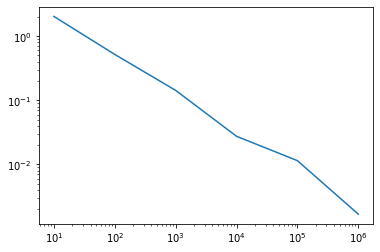

In [22]:
%%time
t = 10 # number of jumps on the boundary
epochs = 25 # binary search time steps
batches = jnp.power(10,np.arange(1,7))
y = jnp.array([[0.5,0.3]]).transpose()

key = random.PRNGKey(int(time.time()))
keys = random.split(key, len(batches))

values = np.zeros(len(batches))
for i in range(len(batches)):
  values[i] = computeSoln(t, epochs, batches[i], y, keys[i])[0]

print(values)
error = np.abs(values - 0.3)
plt.plot(batches, error)
plt.xscale('log')
plt.yscale('log')